In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from ase import Atoms
from ase import build
from ase.io import read, write
from ase.visualize import view

import abtem

(user_guide:walkthrough:atomic_models)=
# Atomic models with ASE
abTEM uses the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating model atomic structures {cite}`ase`. ASE is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is also used in conjunction with other simulation codes such as GPAW for running DFT simulations. Here, we introduce the set of features of ASE needed for image simulations; please refer to the ASE documentation for a more general introduction.

## `Atoms`
The `Atoms` object defines a collection of atoms. Here, is how to set up an N<sub>2</sub> molecule by directly specifying the position of the two nitrogen atoms (in units of Ångstrom):

In [2]:
n2 = Atoms('2N', positions=[(0., 0., 0.), (0., 0., 1.10)], cell=[2, 2, 2])

A basic *abTEM* simulation only uses the positional coordinates, atomic numbers and the unit cell for creating electrostatic potentials. Below we access the atomic numbers and the $xyz$ positions as an $n\times 3$ array.

In [3]:
n2.numbers, n2.positions 

(array([7, 7]),
 array([[0. , 0. , 0. ],
        [0. , 0. , 1.1]]))

The cell can be accessed as below.

In [4]:
n2.cell

Cell([2.0, 2.0, 2.0])

In this example, the unit vectors of the cell are all orthogonal and axis-aligned, hence the cell can be given as just the sides of a rectangular cuboid. In general, a cell is defined by three lattice vectors. We print the full representation of the cell below, where each row represents a lattice vector

In [5]:
print(np.array(n2.cell))

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]


```{important}
The multislice algorithm as implemented in *abTEM* always requires that the unit vectors forms are orthogonal and axis-aligned, additionally, the cell must be periodic. Fulfilling both of these constraints, while creating a desired model structure is not always trivial, see [the bottom of this document](orthogonal) for an introduction to the problem.
```

## Import/export

ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import a `.cif`-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>). 

We downloaded the structure file from the [materials project](https://materialsproject.org/). This is an open source library containing a huge number of crystal structures, calculated using density functional theory.

In [6]:
srtio3 = read('./data/SrTiO3.cif')

Of course, we can also write the structure back to disk.  

In [7]:
write('./data/SrTiO3.cif', srtio3)

```{warning}
Unlike some other multislice simulation codes, `abTEM` does not use any Debye-Waller factors or partial occupations embedded in structure files.
```

## Visualizing structures
The simplest way to visualize the atoms is the `show_atoms` function. This function embeds a 2D orthogonal projection of the structure perpendicular to a specified plane. For example:

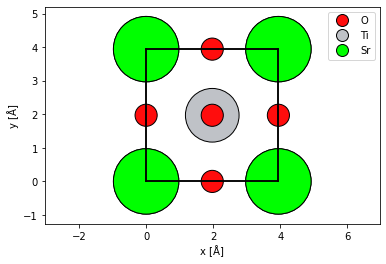

In [77]:
abtem.show_atoms(srtio3, 
                 plane='xy', 
                 scale=.5, 
                 show_periodic=True,
                 legend=True);

To view the atoms in an interactive 3d viewer, we can use ASE's `view` function.

In [8]:
# may not work in remote environments (e.g. binder)
# view(srtio3) 

If you are working in a remote environment or prefer to embed the viewer in the notebook, you can install [nglview](https://github.com/nglviewer/nglview). This will allow you to use the `nglview` backend for the `view` function.

In [9]:
# may not work without installing additional dependencies
# view(srtio3, viewer='nglview') 

## Bulding structures

In addition to importing structures, ASE has tools for procedurally creating many common structures:

* Common bulk crystals: [`ase.build.bulk`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.bulk)
* Bulk structures by its spacegroup: [`ase.spacegroup.crystal`](https://wiki.fysik.dtu.dk/ase/ase/spacegroup/spacegroup.html?highlight=crystal)
* Carbon nanotubes: [`ase.build.nanotube`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes)
* Nanoparticles: [`ase.cluster`](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html)

As an example, we create a nanoparticle of gold by specifying 6 layers in the (100) directions, 9 in the (110) directions and 5 in the (111) directions

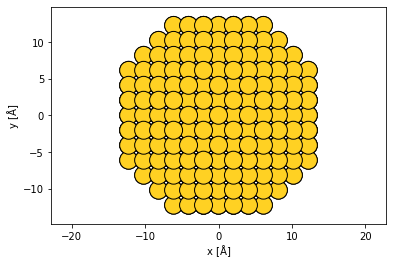

In [78]:
from ase.cluster import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [6, 9, 5]
latticeconstant = 4.08

nanoparticle = FaceCenteredCubic('Au', surfaces, layers, latticeconstant=latticeconstant)

abtem.show_atoms(nanoparticle, scale=.9);

## Manipulating structures

The structure you import or build may not match your requirements or the requirements of *abTEM*. Here, we exemplify the most common manipulations needed for modifying atomic models for image simulation.

### Rotating structures
A common problem when creating model structures is choosing the imaging direction. *abTEM* always assumes that the imaging electrons travels along the $z$-axis in the direction from negative to positive coordinate values, hence choosing the propagation direction requires manipulating the atomic structure.

In this example, we rotate the nanoparticle into the (110) zone axis with the (100)-facet aligned with the $x$-axis. We first [`the bottom of this documentrotate`](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate) the atoms by $45 \ \mathrm{deg.}$ around $x$ and then by $\sim35.26 \ \mathrm{deg.}$ around $z$.

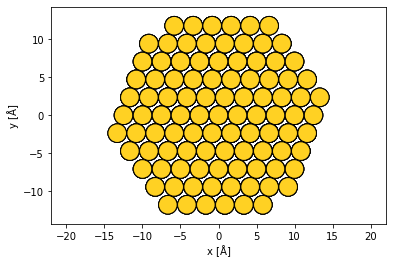

In [80]:
rotated_nanoparticle = nanoparticle.copy()

rotated_nanoparticle.rotate(45, 'x')

rotated_nanoparticle.rotate(np.degrees(np.arctan(1 / np.sqrt(2))), 'z')

abtem.show_atoms(rotated_nanoparticle, scale=.9);

### Adding vacuum

The unit cell of the nanotube above has *zero extent*.

In [33]:
rotated_nanoparticle.cell

Cell([0.0, 0.0, 0.0])

The extent of the unit cell determines the extent of the wave function, hence this is an invalid cell. We can use `.center` to add vacuum around the unit cell.

In [81]:
centered_nanoparticle = rotated_nanoparticle.copy()

centered_nanoparticle.center(vacuum=2)

Showing the unit cell, we now see that there is a vacuum of $2 \ \mathrm{Å}$ separating the outermost atoms and the unit cell boundary.   

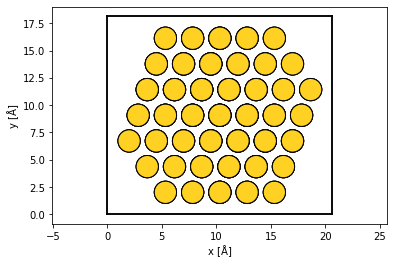

In [35]:
abtem.show_atoms(centered_nanoparticle);

### Rotation of bulk structures

Rotating the nanoparticle without considering the unit cell was only possible because the structure did not require periodicity. For periodic structures, we can use [`surface`](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html#create-specific-non-common-surfaces) function for picking the [zone axis](https://en.wikipedia.org/wiki/Zone_axis) of a given structure by providing the Miller indices. Below we create a SrTiO<sub>3</sub> structure in the (110) zone axis.

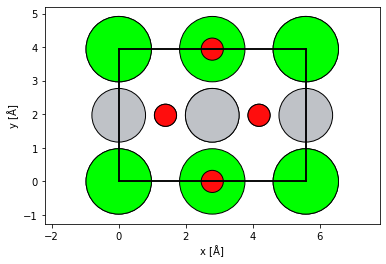

In [64]:
srtio3_110 = build.surface(srtio3, indices=(1, 1, 0), layers=2, periodic=True)

abtem.show_atoms(srtio3_110, plane='xy', show_periodic=True, scale=.5);

```{seealso}
For rotations that does not correspond with a low-index zone axis, see [our introduction to creating arbitrary orthogonal structures](orthogonal) at the bottom of this document.
```

### Repeating the structure

It is often necessary to repeat the unit cell. For example, you may need to increase the thickness of the structure by repeating it along $z$. In STEM, the $xy$-extent of the model structure have to be large enough to accomodate the size of the probe while preventing self-interaction with its periodic images.

In ASE structures may be repeated by multiplying them.

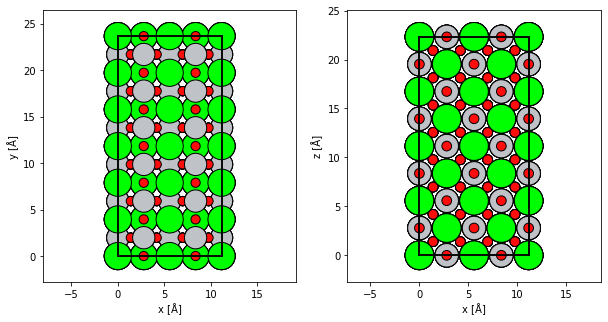

In [74]:
repeated_srtio3 = srtio3_110 * (2, 6, 4)

_, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
abtem.show_atoms(repeated_srtio3, ax=ax1, show_periodic=True)
abtem.show_atoms(repeated_srtio3, ax=ax2, plane='xz', show_periodic=True);

### Conditionally modifying atoms

The atomic positions and numbers are just `numpy` arrays and can be modified directly. We create a SrTiO<sub>3</sub> / LaTiO<sub>3</sub> interface changing the atomic number of half the Sr atoms.

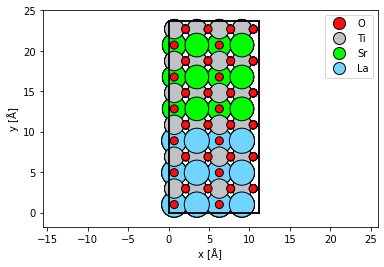

In [75]:
sto_lto_interface = repeated_srtio3.copy()

# select atoms with atomic number 38
mask_sr = sto_lto_interface.numbers == 38 

# select atoms to the left of center
mask_left_side = sto_lto_interface.positions[:, 1] < sto_lto_interface.cell[1,1] / 2 

# combine selection
mask_combined = mask_sr * mask_left_side

# assign new atomic numbers to selection
sto_lto_interface.numbers[mask_combined] = 57

sto_lto_interface.center()

abtem.show_atoms(sto_lto_interface, show_periodic=True, legend=True);

In [76]:
write('data/STO_LTO.cif', sto_lto_interface)

/opt/anaconda3/envs/abtem-dask/lib/python3.8/site-packages/ase/io/cif.py:787: UserWarning: Occupancies present but no occupancy info for "{symbol}"
  warnings.warn(str(err))


As an alternative, you can use the getter and setter methods `get_atomic_numbers` and `set_atomic_numbers`.

### Scaling structures

Here, we randomly substitutionally dope the structures by making the titanium atoms into indium atoms with a probability of 10 %.

In [40]:
scaled_sto_lto_interface = sto_lto_interface.copy()

a_sr = 3.905
a_la = 3.97
a_new = (3.905 + 3.97) / 2
a_old = srtio3.cell[0, 0]

new_cell = sto_lto_interface.cell * a_new / a_old

scaled_sto_lto_interface.set_cell(new_cell, scale_atoms=True)

### Combining multiple structures

Some complex hetero-structures can only be created by combining multiple component structures. As an example we create a support the nanoparticle from above on a simple model of amorphous carbon.

Below, the amorphous carbon is created by randomly displacing the atoms of a diamond structure.

In [47]:
substrate = build.bulk('C', cubic=True)

# repeat substrate
substrate *= (7, 4, 7) 

# displace atoms with a standard deviation of 25 % of the bond length
rng = np.random.default_rng(seed=10)
substrate.positions[:] += rng.normal(size=(len(substrate), 3)) * .25 * 1.54 

# wrap the atoms displaced outside the cell back into the cell 
substrate.wrap()

We delete the atoms with a value of $y$ less than $\mathrm{10} \ Å$, then the nanoparticle is centered with respect to the substrate.

In [53]:
cut_nanoparticle = centered_nanoparticle.copy()

mask = cut_nanoparticle.positions[:, 1] < 5

# deletion *requires* providing the indices
del cut_nanoparticle[np.where(mask)[0]]

# center nanoparticle relative to substrate
cut_nanoparticle.set_cell(substrate.cell)
cut_nanoparticle.center()

# shift nanoparticle in the y-direction
cut_nanoparticle.positions[:, 1] += 12

The substrate and nanoparticle and be combined by adding the models, lastly the models are centered along the $z$-axis with a vacuum of $5 \ \mathrm{Å}$

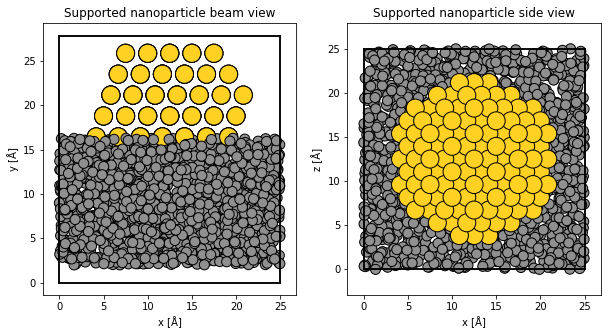

In [54]:
supported_nanoparticle = substrate + cut_nanoparticle

supported_nanoparticle.center(axis=1, vacuum=2)

_, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
abtem.show_atoms(supported_nanoparticle, ax=ax1, title='Supported nanoparticle beam view')
abtem.show_atoms(supported_nanoparticle, ax=ax2, plane='xz', title='Supported nanoparticle side view');

In [55]:
write('data/supported_nanoparticle.cif', supported_nanoparticle)

(orthogonal)=
## Orthogonal and periodic supercells

The multislice algorithm requires an orthogonal periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is not always trivial. abTEM has a tool for solving this problem. To demonstrate the tool, we create a graphene structure with the minimal hexagonal unit cell. 

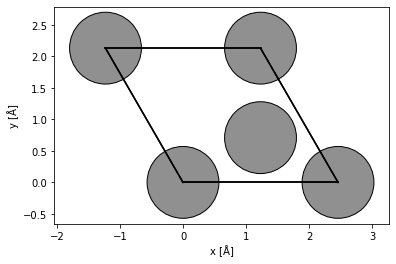

In [25]:
from ase import build

graphene = build.graphene(vacuum=10)

abtem.show_atoms(graphene, show_periodic=True);

The minimal unit cell of graphene is hexagonal, whereas the multislice algorithm requires an orthogonal unit cell. To make the unit cell orthogonal, we can use the abTEM `orthogonalize_cell` function. It is not always possible to make a periodic cell orthogonal without introducing some strain, hence we can return the strain tensor.

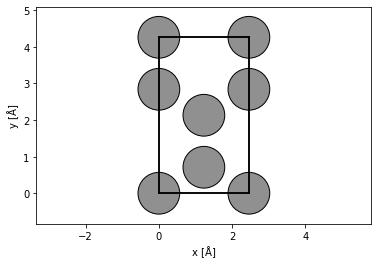

In [26]:
from abtem.structures import orthogonalize_cell, pretty_print_transform

orthogonal_graphene, transform = orthogonalize_cell(graphene, return_transform=True)

abtem.show_atoms(orthogonal_graphene, show_periodic=True);

Hexagonal cells can be made orthogonal by doubling its size without introducing any strain.

In [27]:
pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


A common, less trivial example, is the creation of models with a specific rotation relative to the beam. Here, we want to view FCC gold at a 10 degree angle.

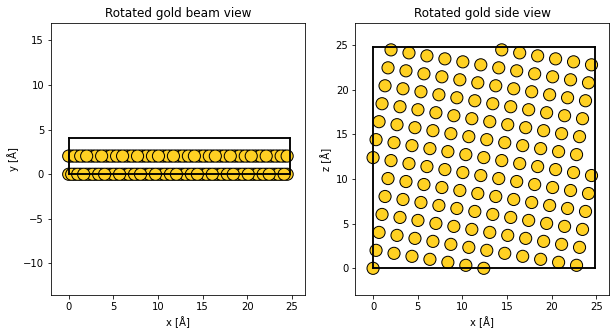

In [28]:
desired_rotation = 10

gold = build.bulk('Au', cubic=True)

gold.rotate(desired_rotation, 'y', rotate_cell=True)

gold, transform = orthogonalize_cell(gold, max_repetitions=10, return_transform=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(gold, 
                 ax=ax1, 
                 scale=.5, 
                 title='Rotated gold beam view')

abtem.show_atoms(gold, 
                 ax=ax2, 
                 plane='xz', 
                 scale=.5, 
                 title='Rotated gold side view');

As shown below, creating the rotated structure required an additional rotation of $0.538 \ \mathrm{degrees}$ around the $y$-axis. This means that within the contraint of repeating the structure at most 10 times in either direction, the closest periodic and orthogonal structure is rotated by $10.538 \ \mathrm{degrees}$ and not the desired $10.0 \ \mathrm{degrees}$. This may be close enough, if it is not `max_repetitions` may be increased. For example, within a `max_repetitions` of 20, the required transform is just $-0.008 \ \mathrm{degrees}$ around the $y$-axis.

In [29]:
pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = 0.538, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = -0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000
